<html><head><meta content="text/html; charset=UTF-8" http-equiv="content-type"><style type="text/css">ol</style></head><body class="c5"><p class="c0 c4"><span class="c3"></span></p><p class="c2 title" id="h.rrbabt268i6e"><h1>CaImAn&rsquo;s Demo pipeline</h1></p><p class="c0"><span class="c3">This notebook will help to demonstrate the process of CaImAn and how it uses different functions to denoise, deconvolve and demix neurons from a Calcium Imaging Video. </span></p>
<p><img src="docs/img/quickintro.png" /></p>
<p class="c0"><span class="c3">More information can be found in CaImAn&rsquo;s documentation. </span></p>
</html>



In [2]:
#!/usr/bin/env python
from __future__ import division
from __future__ import print_function
from builtins import zip
from builtins import str
from builtins import map
from builtins import range
from past.utils import old_div
try:
    get_ipython().magic(u'load_ext autoreload')
    get_ipython().magic(u'autoreload 2')    
except:
    print('Not IPYTHON')
import numpy as np
import matplotlib.pyplot as plt
get_ipython().magic(u'matplotlib qt')   
import caiman as cm
from caiman.source_extraction import cnmf
from caiman.utils.utils import download_demo
from caiman.utils.visualization import inspect_correlation_pnr
from caiman.components_evaluation import estimate_components_quality_auto
from caiman.motion_correction import motion_correct_oneP_rigid
import os
import cv2
from caiman.utils.visualization import plot_contours, nb_view_patches, nb_plot_contour
from caiman.base.rois import register_ROIs

try:
    cv2.setNumThreads(1)
except:
    print('Open CV is naturally single threaded')
import bokeh.plotting as bpl
bpl.output_notebook()

/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Loading BokehJS ...

### Setup some parameters
many of them will be set directly calling the CNMF object

In [2]:
folder_1 = '/home/sebastian/Documents/data/'
session_1 = 'recording_20170710_120637'
fname_1 = sorted([folder_1+f for f in os.listdir(folder_1) if (session_1 in f and '.tif' in f)])

folder_2 = '/home/sebastian/Documents/data/'
session_2 = 'recording_20170710_120637'
fname_2 = sorted([folder_2+f for f in os.listdir(folder_2) if (session_2 in f and '.tif' in f)])

frate = 10 # movie frame rate
gSig = 4   # gaussian width of a 2D gaussian kernel, which approximates a neuron
gSiz = 10  # average diameter of a neuron
do_motion_correction = True

Download the dataset if not already present

In [3]:
fname_2

['/home/sebastian/Documents/data/recording_20170710_120637-000.tif',
 '/home/sebastian/Documents/data/recording_20170710_120637-001.tif',
 '/home/sebastian/Documents/data/recording_20170710_120637-002.tif',
 '/home/sebastian/Documents/data/recording_20170710_120637-003.tif',
 '/home/sebastian/Documents/data/recording_20170710_120637-004.tif']

In [4]:
m_orig_1 = cm.load_movie_chain(fname_1)
m_orig_2 = cm.load_movie_chain(fname_2)
downsample_ratio = 0.2
offset_mov_1 = -np.min(m_orig_1[:100]).astype(np.float32)  # make the dataset mostly non-negative
offset_mov_2 = -np.min(m_orig_2[:100]).astype(np.float32)
#m_raw.resize(1, 1, downsample_ratio).play(
#gain=2, offset=offset_mov, fr=30, magnification=1)

100%|██████████| 5/5 [00:24<00:00,  4.86s/it]


Crop stationary edges:

In [6]:

m_orig_1 = m_orig_1.interactive_crop(
    gain=1, offset = -offset_mov_1, fr=30)   # play movie (press q to exit

print(m_orig_1.shape)

m_orig_2 = m_orig_2.interactive_crop(size = (m_orig_1.shape[1],m_orig_1.shape[2]),
   gain=1, offset = -offset_mov_2, fr=30)   # play movie (press q to exit

print(m_orig_2.shape)

offset_mov_1 = -np.min(m_orig_1[:100])
offset_mov_2 = -np.min(m_orig_2[:100])
m_orig_1.save('cropped_1.tif')
m_orig_2.save('cropped_2.tif')

Select region, press [c] to crop
(6454, 815, 969)
Select region, press [c] to crop
(6454, 815, 969)
.tif
tifffile package not found, using skimage instead for imsave
.tif
tifffile package not found, using skimage instead for imsave


In [14]:
print(m_orig_1.shape,m_orig_2.shape)

cm.concatenate([m_orig_1.resize(1, 1, downsample_ratio)-offset_mov_1,
                m_orig_2.resize(1, 1, downsample_ratio)-offset_mov_2], axis=2).play(fr=60, gain=1, magnification=1, offset=0)



(6454, 701, 912) (6454, 701, 912)
Resizing in chunks because of opencv bug
[0, 3359]
reshaping along z
[3359, 6454]
reshaping along z
Resizing in chunks because of opencv bug
[0, 3359]
reshaping along z
[3359, 6454]
reshaping along z


### (Re)start cluster.  

In [7]:
try:
    dview.terminate() # stop it if it was running
except:
    pass

c, dview, n_processes = cm.cluster.setup_cluster(backend='local', # use this one
                                                 n_processes=16,  # number of process to use, if you go out of memory try to reduce this one
                                                 )

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
160
160
160
160
160
160
160
160
160
160
160
160
160
160
160
160
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
180
180
180
180
180
180


### Creation of a memory mappable file. 
    - Performs motion correction and simultaneously creates a memory mappable file in F order
    - Transforms into C order (much more efficient for parallel processing
    - If you have multiple files there are ways to process many at the same time (not shown)
    

Play the movie (optional). This will require loading the movie in memory which in general is not needed by the pipeline. Displaying the movie uses the OpenCV library. Press `q` to close the video panel. **BEWARE** the movie may appear in the background!

Rigid Motion Correction
2.111474
-0.6895360594987869


/home/sebastian/Documents/CaImAn/caiman/base/movies.py:261: UserWarning: ** Pixels averages are too negative. Removing 1 percentile. **
  '** Pixels averages are too negative. Removing 1 percentile. **')
/home/sebastian/Documents/CaImAn/caiman/base/movies.py:280: UserWarning: Pixels averages are too negative for template. Removing 1 percentile.
  'Pixels averages are too negative for template. Removing 1 percentile.')


Frame 100
Frame 200
cubic interpolation
Frame 100
Frame 200
-0.6895360594987869
Frame 100
Frame 200
cubic interpolation
Frame 100
Frame 200
-0.6895360594987869
Frame 100
Frame 200
cubic interpolation
Frame 100
Frame 200
Adding to movie 2.111474
0
saving!
** Startting parallel motion correction **
** Finished parallel motion correction **
0.32138717
Rigid Motion Correction
2.0384367
-0.6905319339036942
Frame 100
Frame 200
cubic interpolation
Frame 100
Frame 200
-0.6905319339036942
Frame 100
Frame 200
cubic interpolation
Frame 100
Frame 200
-0.6905319339036942
Frame 100
Frame 200
cubic interpolation
Frame 100
Frame 200
Adding to movie 2.0384367
0
saving!
** Startting parallel motion correction **
** Finished parallel motion correction **
0.3212536


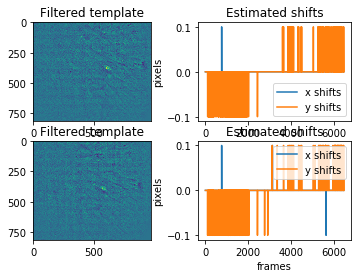

cropped_1_rig__d1_815_d2_969_d3_1_order_F_frames_6454_.mmap
loading in memory
mmap
cropped_2_rig__d1_815_d2_969_d3_1_order_F_frames_6454_.mmap
loading in memory
mmap


In [8]:

mc_1 = motion_correct_oneP_rigid('cropped_1.tif',                        # name of file to motion correct
                           gSig_filt = [gSig]*2,                 # size of filter, xhange this one if algorithm does not work 
                           max_shifts = [3,3],                   # maximum shifts allowed in each direction 
                           dview=dview, 
                           splits_rig = 16,                      # number of chunks for parallelizing motion correction (remember that it should hold that length_movie/num_splits_to_process_rig>100) 
                           save_movie = True)                    # whether to save movie in memory mapped format

new_templ = mc_1.total_template_rig
plt.subplot(2,2,1)    
plt.title('Filtered template')
plt.imshow(new_templ)       #% plot template
plt.subplot(2,2,2)
plt.title('Estimated shifts')
plt.plot(mc_1.shifts_rig)     #% plot rigid shifts
plt.legend(['x shifts', 'y shifts'])
plt.xlabel('frames')
plt.ylabel('pixels')

mc_2 = motion_correct_oneP_rigid('cropped_2.tif',                        # name of file to motion correct
                           gSig_filt = [gSig]*2,                 # size of filter, xhange this one if algorithm does not work 
                           max_shifts = [3,3],                   # maximum shifts allowed in each direction 
                           dview=dview, 
                           splits_rig = 16,                      # number of chunks for parallelizing motion correction (remember that it should hold that length_movie/num_splits_to_process_rig>100) 
                           save_movie = True)                  # whether to save movie in memory mapped format

new_templ = mc_2.total_template_rig
plt.subplot(2,2,3)    
plt.title('Filtered template')
plt.imshow(new_templ)       #% plot template
plt.subplot(2,2,4)
plt.title('Estimated shifts')
plt.plot(mc_2.shifts_rig)     #% plot rigid shifts
plt.legend(['x shifts', 'y shifts'])
plt.xlabel('frames')
plt.ylabel('pixels')

plt.show()

bord_px_rig_1 = np.ceil(np.max(mc_1.shifts_rig)).astype(np.int)     #borders to eliminate from movie because of motion correction        
fname_new_1 = cm.save_memmap(mc_1.fname_tot_rig, base_name='memmap_', order = 'C') # transforming memoruy mapped file in C order (efficient to perform computing)

bord_px_rig_2 = np.ceil(np.max(mc_2.shifts_rig)).astype(np.int)     #borders to eliminate from movie because of motion correction        
fname_new_2 = cm.save_memmap(mc_2.fname_tot_rig, base_name='memmap_', order = 'C') # transforming memoruy mapped file in C order (efficient to perform computing)

# load memory mappable file
Yr_1, dims_1, T_1 = cm.load_memmap(fname_new_1)
Y_1 = Yr_1.T.reshape((T_1,) + dims_1, order='F')

Yr_2, dims_2, T_2 = cm.load_memmap(fname_new_2)
Y_2 = Yr_2.T.reshape((T_2,) + dims_2, order='F')


In [10]:
m_corr = cm.movie(Y_1)
downsample_ratio = 1.
offset_corr = -np.min(m_corr[:100])  # make the dataset mostly non-negative
m_corr.resize(1, 1, downsample_ratio).play(
gain=1, offset=offset_mov_1, fr=30, magnification=1)

Resizing in chunks because of opencv bug
[0, 2719]
[2719, 5438]
[5438, 6454]


In [9]:
# compute some summary images (correlation and peak to noise)
cn_filter_orig_1, pnr_orig_1 = cm.summary_images.correlation_pnr(m_orig_1,gSig=gSig, swap_dim=False) # change swap dim if output looks weird, it is a problem with tiffile
cn_filter_1, pnr_1 = cm.summary_images.correlation_pnr(Y_1, gSig=gSig, swap_dim=False) # change swap dim if output looks weird, it is a problem with tiffile
# inspect the summary images and set the parameters
inspect_correlation_pnr(cn_filter_orig_1,pnr_orig_1)
inspect_correlation_pnr(cn_filter_1,pnr_1)

# compute some summary images (correlation and peak to noise)
cn_filter_orig_2, pnr_orig_2 = cm.summary_images.correlation_pnr(m_orig_2,gSig=gSig, swap_dim=False) # change swap dim if output looks weird, it is a problem with tiffile
cn_filter_2, pnr_2 = cm.summary_images.correlation_pnr(Y_2, gSig=gSig, swap_dim=False) # change swap dim if output looks weird, it is a problem with tiffile
# inspect the summary images and set the parameters
inspect_correlation_pnr(cn_filter_orig_2,pnr_orig_2)
inspect_correlation_pnr(cn_filter_2,pnr_2)


TypeError: Cannot cast ufunc subtract output from dtype('float64') to dtype('uint16') with casting rule 'same_kind'

### Inspect summary images and set parameters
Check the optimal values of min_corr and min_pnr by moving slider in the figure that pops up

mmap
[3, -3, 3, -3]
Local correlations..
number of chunks:0 frames: [0, 1500]


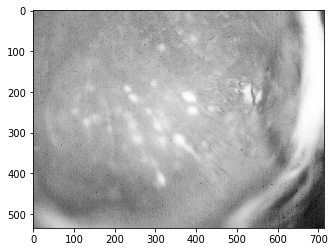

number of chunks:1 frames: [1500, 3000]


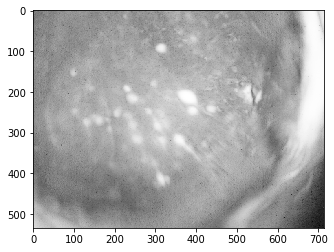

number of chunks:2 frames: [3000, 4500]


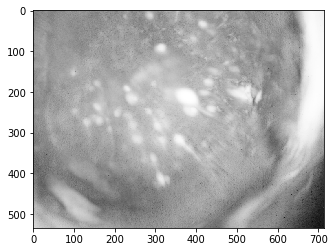

number of chunks:3 frames: [4500, 6000]


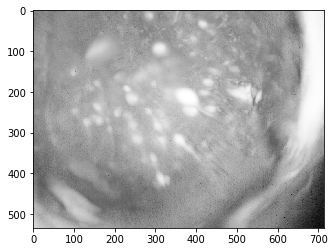

number of chunks:4 frames: [6000, 7500]


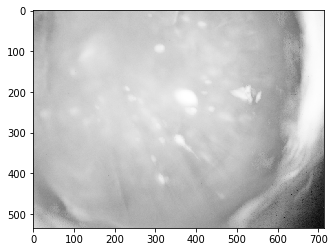

number of chunks:5 frames: [7500, 9000]


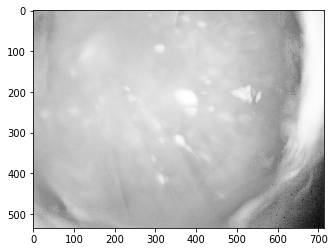

number of chunks:6 frames: [9000, 10500]


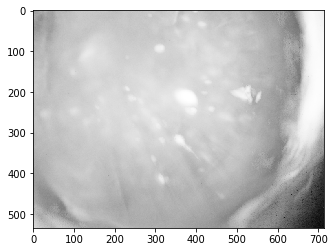

number of chunks:7 frames: [10500, 12000]


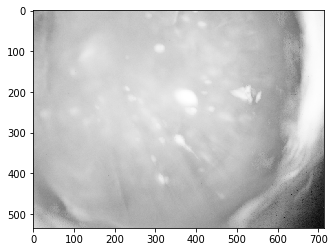

number of chunks:8 frames: [12000, 13500]


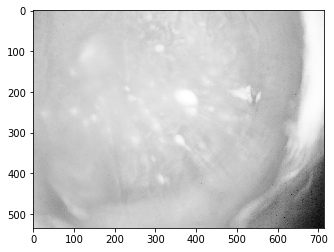

number of chunks:9 frames: [13500, 15000]


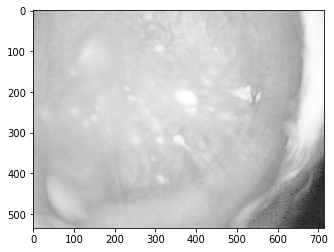

number of chunks:10 frames: [15000, 16500]


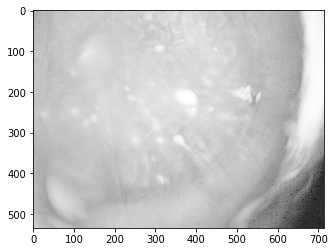

number of chunks:11 frames: [16500, 18000]


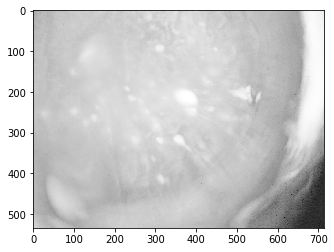

number of chunks:12 frames: [18000, 19500]


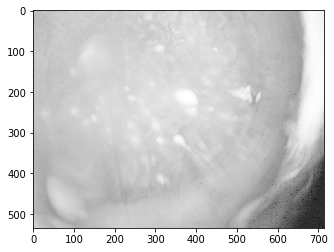

number of chunks:13 frames: [19500, 21000]


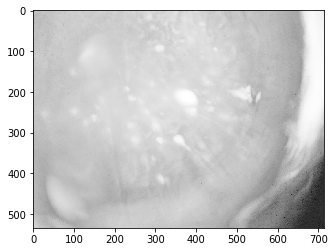

number of chunks:14 frames: [21000, 22500]


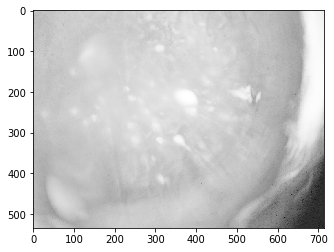

number of chunks:15 frames: [22500, 24000]


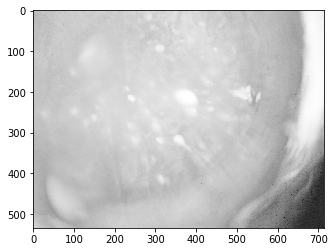

number of chunks:16 frames: [24000, 25500]


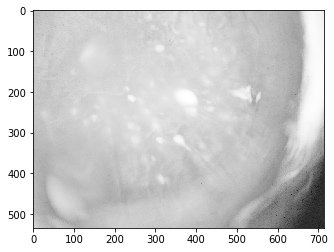

number of chunks:17 frames: [25500, 27000]


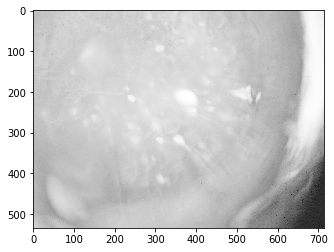

number of chunks:18 frames: [27000, 28500]


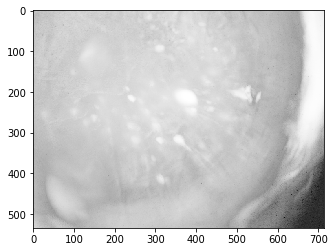

number of chunks:19 frames: [28500, 30000]


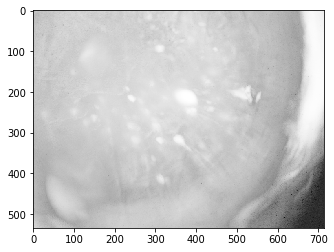

number of chunks:20 frames: [30000, 31519]


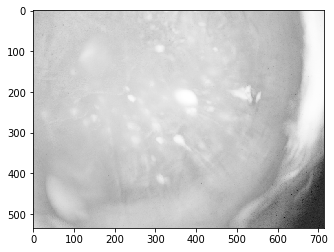

(31519, 534, 714)
Compute Smoothness.. 
Compute correlations.. 
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
1740

In [7]:
# load memory mappable file
file = "/home/sebastian/Desktop/dumped_files/memmap__d1_540_d2_720_d3_1_order_C_frames_31519_.mmap"
Yr_1, dims, T_1 = cm.load_memmap(file)
mc_1 = Yr_1.T.reshape((T_1,) + dims, order='F')[0:5000,:,:]


#% compute metrics for the results (TAKES TIME!!)
final_size = np.subtract(dims, 2 * 3) # remove pixels in the boundaries
winsize = 100
swap_dim = False
resize_fact_flow = .2    # downsample for computing ROF

tmpl_rig, correlations_orig, flows_orig, norms_orig, crispness_orig = cm.motion_correction.compute_metrics_motion_correction(
    file, final_size[0], final_size[1], swap_dim, winsize=winsize, play_flow=False, resize_fact_flow=resize_fact_flow)

# tmpl_rig, correlations_rig, flows_rig, norms_rig, crispness_rig = cm.motion_correction.compute_metrics_motion_correction(
#     mc_1.fname_tot_rig[0], final_size[0], final_size[1],
#     swap_dim, winsize=winsize, play_flow=False, resize_fact_flow=resize_fact_flow)



In [41]:
# print crispness values
#print('Crispness original: '+ str(int(crispness_orig)))
#[tmpl_rig, correlations_orig, flows_orig, norms_orig, crispness_orig]

#flow = (np.array(flows_orig))
#plt.imshow((flow**2).sum(0)[:,:,1])
crispness_orig


991.42236

In [10]:
#%% plot the results of Residual Optical Flow
fls = [ mc_1.fname_tot_rig[0][:-5]+ '_metrics.npz']
        #mc.fname[0][:-5] + '_metrics.npz']

#print('Running time rigid motion: ' + str(t_rigid))
#print('Running time piecewise motion: ' + str(t_pw))

plt.figure(figsize = (20,10))
for cnt, fl, metr in zip(range(len(fls)),fls,['raw']):
    with np.load(fl) as ld:
        print(ld.keys())
        print(fl)
        print(str(np.mean(ld['norms'])) + '+/-' + str(np.std(ld['norms'])) +
              ' ; ' + str(ld['smoothness']) + ' ; ' + str(ld['smoothness_corr']))
        
        plt.subplot(len(fls), 3, 1 + 3 * cnt)
        plt.ylabel(metr)
        try:
            mean_img = np.mean(
            cm.load(fl[:-12] + '.mmap'), 0)[12:-12, 12:-12]
        except:
            try:
                mean_img = np.mean(
                    cm.load(fl[:-12] + '.tif'), 0)[12:-12, 12:-12]
            except:
                mean_img = np.mean(
                    cm.load(fl[:-12] + '.hdf5'), 0)[12:-12, 12:-12]
                    
        lq, hq = np.nanpercentile(mean_img, [.5, 99.5])
        plt.imshow(mean_img, vmin=lq, vmax=hq)
        plt.title('Mean')
        plt.subplot(len(fls), 3, 3 * cnt + 2)
        plt.imshow(ld['img_corr'], vmin=0, vmax=.35)
        plt.title('Corr image')
        plt.subplot(len(fls), 3, 3 * cnt + 3)
        #plt.plot(ld['norms'])
        #plt.xlabel('frame')
        #plt.ylabel('norm opt flow')
        #plt.subplot(len(fls), 3, 3 * cnt + 3)
        flows = ld['flows']
        plt.imshow(np.mean(
        np.sqrt(flows[:, :, :, 0]**2 + flows[:, :, :, 1]**2), 0), vmin=0, vmax=0.3)
        plt.colorbar()
        plt.title('Mean optical flow')      

AttributeError: 'memmap' object has no attribute 'fname_tot_rig'

### Inspect summary images and set parameters
Check the optimal values of min_corr and min_pnr by moving slider in the figure that pops up

In [ ]:

min_corr = .8 # min correlation of peak (from correlation image)
min_pnr = 10 # min peak to noise ratio
min_SNR = 3 # adaptive way to set threshold on the transient size
r_values_min = 0.85  # threshold on space consistency (if you lower more components will be accepted, potentially with worst quality)
decay_time = 0.4  #decay time of transients/indocator

In [ ]:
### Set CNMF parameters and run it

In [ ]:
cnm_1 = cnmf.CNMF(n_processes=n_processes, 
                method_init='corr_pnr',                 # use this for 1 photon
                k=70,                                   # neurons per patch
                gSig=(3, 3),                            # half size of neuron
                gSiz=(10, 10),                          # in general 3*gSig+1
                merge_thresh=.8,                        # threshold for merging
                p=1,                                    # order of autoregressive process to fit
                dview=dview,                            # if None it will run on a single thread
                tsub=2,                                 # downsampling factor in time for initialization, increase if you have memory problems             
                ssub=2,                                 # downsampling factor in space for initialization, increase if you have memory problems
                Ain=None,                               # if you want to initialize with some preselcted components you can pass them here as boolean vectors
                rf=(40, 40),                            # half size of the patch (final patch will be 100x100)
                stride=(20, 20),                        # overlap among patches (keep it at least large as 4 times the neuron size)
                only_init_patch=True,                   # just leave it as is
                gnb=16,                                 # number of background components
                nb_patch=16,                            # number of background components per patch
                method_deconvolution='oasis',           #could use 'cvxpy' alternatively
                low_rank_background=True,               #leave as is
                update_background_components=True,      # sometimes setting to False improve the results
                min_corr=min_corr,                      # min peak value from correlation image 
                min_pnr=min_pnr,                        # min peak to noise ration from PNR image
                normalize_init=False,                   # just leave as is
                center_psf=True,                        # leave as is for 1 photon
                del_duplicates=True)                    # whether to remove duplicates from initialization
cnm_1.fit(Y_1)

cnm_2 = cnmf.CNMF(n_processes=n_processes, 
                method_init='corr_pnr',                 # use this for 1 photon
                k=70,                                   # neurons per patch
                gSig=(3, 3),                            # half size of neuron
                gSiz=(10, 10),                          # in general 3*gSig+1
                merge_thresh=.8,                        # threshold for merging
                p=1,                                    # order of autoregressive process to fit
                dview=dview,                            # if None it will run on a single thread
                tsub=2,                                 # downsampling factor in time for initialization, increase if you have memory problems             
                ssub=2,                                 # downsampling factor in space for initialization, increase if you have memory problems
                Ain=None,                               # if you want to initialize with some preselcted components you can pass them here as boolean vectors
                rf=(40, 40),                            # half size of the patch (final patch will be 100x100)
                stride=(20, 20),                        # overlap among patches (keep it at least large as 4 times the neuron size)
                only_init_patch=True,                   # just leave it as is
                gnb=16,                                 # number of background components
                nb_patch=16,                            # number of background components per patch
                method_deconvolution='oasis',           #could use 'cvxpy' alternatively
                low_rank_background=True,               #leave as is
                update_background_components=True,      # sometimes setting to False improve the results
                min_corr=min_corr,                      # min peak value from correlation image 
                min_pnr=min_pnr,                        # min peak to noise ration from PNR image
                normalize_init=False,                   # just leave as is
                center_psf=True,                        # leave as is for 1 photon
                del_duplicates=True)                    # whether to remove duplicates from initialization

cnm_2.fit(Y_2)

plot contours of identified components against correlation image

In [ ]:

plt.subplot(1,2,1)

crd_1 = cm.utils.visualization.plot_contours(cnm_1.A, cn_filter_1, thr=.1, vmax=0.95)

plt.subplot(1,2,2)
crd_2 = cm.utils.visualization.plot_contours(cnm_2.A, cn_filter_2, thr=.1, vmax=0.95)


In [ ]:
### Match the two without aligning:

In [ ]:
matched_ROIs_1, matched_ROIs_2, non_matched_1, non_matched_2, performance = register_ROIs(
Jupyter Notebook
demo_pipeline_cnmfE_match Last Checkpoint: 04/30/2018 (autosaved) Current Kernel Logo 

Python 3

    File
    Edit
    View
    Insert
    Cell
    Kernel
    Widgets
    Help

CaImAn’s Demo pipeline

This notebook will help to demonstrate the process of CaImAn and how it uses different functions to denoise, deconvolve and demix neurons from a Calcium Imaging Video.

More information can be found in CaImAn’s documentation.

#!/usr/bin/env python

from __future__ import division

from __future__ import print_function

from builtins import zip

from builtins import str

from builtins import map

from builtins import range

from past.utils import old_div

try:

    get_ipython().magic(u'load_ext autoreload')

    get_ipython().magic(u'autoreload 2')    

except:

    print('Not IPYTHON')

import numpy as np

import matplotlib.pyplot as plt

get_ipython().magic(u'matplotlib qt')   

import caiman as cm

from caiman.source_extraction import cnmf

from caiman.utils.utils import download_demo

from caiman.utils.visualization import inspect_correlation_pnr

from caiman.components_evaluation import estimate_components_quality_auto

from caiman.motion_correction import motion_correct_oneP_rigid

import os

import cv2

from caiman.utils.visualization import plot_contours, nb_view_patches, nb_plot_contour

from caiman.base.rois import register_ROIs

​

try:

    cv2.setNumThreads(1)

except:

    print('Open CV is naturally single threaded')

import bokeh.plotting as bpl

bpl.output_notebook()

/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters

BokehJS 0.12.15 successfully loaded.
Setup some parameters

many of them will be set directly calling the CNMF object

folder_1 = '/home/sebastian/Documents/data/'

session_1 = 'recording_20170710_120637'

fname_1 = sorted([folder_1+f for f in os.listdir(folder_1) if (session_1 in f and '.tif' in f)])

​

folder_2 = '/home/sebastian/Documents/data/'

session_2 = 'recording_20170710_120637'

fname_2 = sorted([folder_2+f for f in os.listdir(folder_2) if (session_2 in f and '.tif' in f)])

​

frate = 10 # movie frame rate

gSig = 4   # gaussian width of a 2D gaussian kernel, which approximates a neuron

gSiz = 10  # average diameter of a neuron

do_motion_correction = True

Download the dataset if not already present

fname_2

['/home/sebastian/Documents/data/recording_20170710_120637-000.tif',
 '/home/sebastian/Documents/data/recording_20170710_120637-001.tif',
 '/home/sebastian/Documents/data/recording_20170710_120637-002.tif',
 '/home/sebastian/Documents/data/recording_20170710_120637-003.tif',
 '/home/sebastian/Documents/data/recording_20170710_120637-004.tif']

m_orig_1 = cm.load_movie_chain(fname_1)

m_orig_2 = cm.load_movie_chain(fname_2)

downsample_ratio = 0.2

offset_mov_1 = -np.min(m_orig_1[:100]).astype(np.float32)  # make the dataset mostly non-negative

offset_mov_2 = -np.min(m_orig_2[:100]).astype(np.float32)

#m_raw.resize(1, 1, downsample_ratio).play(

#gain=2, offset=offset_mov, fr=30, magnification=1)

100%|██████████| 5/5 [04:03<00:00, 48.80s/it]
100%|██████████| 5/5 [00:24<00:00,  4.86s/it]

Crop stationary edges:

​

m_orig_1 = m_orig_1.interactive_crop(

    gain=1, offset = -offset_mov_1, fr=30)   # play movie (press q to exit

​

print(m_orig_1.shape)

​

m_orig_2 = m_orig_2.interactive_crop(size = (m_orig_1.shape[1],m_orig_1.shape[2]),

   gain=1, offset = -offset_mov_2, fr=30)   # play movie (press q to exit

​

print(m_orig_2.shape)

​

offset_mov_1 = -np.min(m_orig_1[:100])

offset_mov_2 = -np.min(m_orig_2[:100])

m_orig_1.save('cropped_1.tif')

m_orig_2.save('cropped_2.tif')

Select region, press [c] to crop
(6454, 815, 969)
Select region, press [c] to crop
(6454, 815, 969)
.tif
tifffile package not found, using skimage instead for imsave
.tif
tifffile package not found, using skimage instead for imsave

print(m_orig_1.shape,m_orig_2.shape)

​

cm.concatenate([m_orig_1.resize(1, 1, downsample_ratio)-offset_mov_1,

                m_orig_2.resize(1, 1, downsample_ratio)-offset_mov_2], axis=2).play(fr=60, gain=1, magnification=1, offset=0)

​

​

(6454, 701, 912) (6454, 701, 912)
Resizing in chunks because of opencv bug
[0, 3359]
reshaping along z
[3359, 6454]
reshaping along z
Resizing in chunks because of opencv bug
[0, 3359]
reshaping along z
[3359, 6454]
reshaping along z

(Re)start cluster.

try:

    dview.terminate() # stop it if it was running

except:

    pass

​

c, dview, n_processes = cm.cluster.setup_cluster(backend='local', # use this one

                                                 n_processes=16,  # number of process to use, if you go out of memory try to reduce this one

                                                 )

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
160
160
160
160
160
160
160
160
160
160
160
160
160
160
160
160
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
190
190
190
190
190
190
190
190
190
190
190
190
190
190
190
200
200
190
200
200
200
200
200
200
200
200
200
200
200
200
200
200
210
210
210
210
210
210
210
210
210
210
210
210
210
210
210
210
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
230
230
230
230
230
230
230
230
230
230
230
230
230
230
230
230
240
240
240
240
240
240
240
240
240
240
240
240
240
240
240
240
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
300
300
290
300
300
300
300
300
300
300
300
300
300
300
300
310
310
300
310
300
310
310
310
310
310
310
310
310
310
310
310
320
310
320
320
310
320
320
320
320
320
320
320
320
320
320
330
320
320
330
330
330
330
320
330
330
330
330
330
330
330
330
340
330
330
340
340
340
340
330
340
340
340
340
340
340
340
340
350
340
340
350
350
350
350
340
350
350
350
350
350
350
350
350
360
350
350
360
360
360
360
360
350
360
360
360
360
360
360
360
360
370
360
370
370
370
370
370
360
370
370
370
370
370
370
370
380
370
370
380
380
380
380
370
380
380
380
380
380
380
390
380
380
380
380
390
390
390
390
380
390
390
390
390
390
400
390
390
390
390
390
400
400
400
400
390
400
400
400
400
400
400
400
400
400
400
400
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
50
50
50
50
50
50
50
50
50
50
50
50
50
50
60
50
60
60
50
60
60
60
60
60
60
60
60
70
70
70
60
60
70
60
70
60
70
70
60
70
70
70
70
80
80
80
80
70
80
70
80
70
80
80
70
70
80
80
90
80
90
90
90
90
90
90
80
90
80
80
80
90
80
100
90
100
100
90
100
100
100
100
100
90
90
90
100
110
90
90
110
100
110
110
100
110
110
110
110
100
110
120
100
100
120
110
100
120
120
110
100
120
120
120
120
130
120
110
130
110
120
130
110
130
120
110
130
130
110
130
130
140
130
140
120
120
140
130
140
130
140
120
140
140
120
140
120
150
140
150
150
130
130
150
140
140
150
150
150
150
130
130
160
130
160
150
160
140
160
140
150
160
150
160
160
160
140
170
170
140
160
140
170
170
150
170
160
170
170
150
170
160
180
180
150
180
170
150
180
150
180
160
180
180
170
180
170
160
190
190
190
180
160
190
190
170
160
180
190
190
190
160
180
200
200
170
200
190
200
170
200
200
180
200
200
190
170
210
210
190
170
210
180
200
210
210
210
180
210
210
220
190
200
220
180
200
220
180
190
210
220
220
220
220
230
220
230
200
190
210
210
230
190
190
230
220
200
230
230
230
230
240
240
210
240
220
200
220
200
240
230
200
240
210
240
240
240
250
250
250
220
230
230
210
240
250
250
250
210
250
250
220
260
260
210
260
230
240
240
260
250
260
260
220
260
270
270
260
230
220
270
220
240
250
250
270
260
270
270
280
280
270
270
230
280
240
230
230
250
260
260
280
280
280
270
290
290
280
280
290
240
250
240
240
260
270
290
290
270
290
300
300
280
290
290
300
260
250
250
300
280
270
250
310
300
300
310
300
290
300
280
310
270
260
310
320
260
280
310
290
320
310
310
310
260
300
320
290
280
320
330
320
330
270
300
320
320
320
290
330
270
310
300
270
290
330
340
340
330
330
310
330
340
330
280
300
320
280
310
280
340
350
300
350
340
350
340
320
340
340
330
310
290
320
290
290
360
350
360
310
360
350
350
350
350
330
340
320
300
330
300
370
360
320
370
370
360
300
360
360
360
340
350
330
340
310
380
310
370
380
330
370
380
370
370
370
310
350
360
340
350
390
320
380
340
320
390
380
380
390
380
380
360
320
370
400
350
360
390
350
330
400
390
390
330
390
390
400
370
380
330
360
360
370
400
340
400
400
400
400
340
380
390
340
370
370
380
350
350
390
400
380
350
380
390
360
360
400
390
360
390
400
370
370
370
400
400
380
380
380
390
390
390
400
400
400

Creation of a memory mappable file.

- Performs motion correction and simultaneously creates a memory mappable file in F order
- Transforms into C order (much more efficient for parallel processing
- If you have multiple files there are ways to process many at the same time (not shown)

Play the movie (optional). This will require loading the movie in memory which in general is not needed by the pipeline. Displaying the movie uses the OpenCV library. Press q to close the video panel. BEWARE the movie may appear in the background!

​

mc_1 = motion_correct_oneP_rigid('cropped_1.tif',                        # name of file to motion correct

                           gSig_filt = [gSig]*2,                 # size of filter, xhange this one if algorithm does not work 

                           max_shifts = [3,3],                   # maximum shifts allowed in each direction 

                           dview=dview, 

                           splits_rig = 16,                      # number of chunks for parallelizing motion correction (remember that it should hold that length_movie/num_splits_to_process_rig>100) 

                           save_movie = True)                    # whether to save movie in memory mapped format

​

new_templ = mc_1.total_template_rig

plt.subplot(2,2,1)    

plt.title('Filtered template')

plt.imshow(new_templ)       #% plot template

plt.subplot(2,2,2)

plt.title('Estimated shifts')

plt.plot(mc_1.shifts_rig)     #% plot rigid shifts

plt.legend(['x shifts', 'y shifts'])

plt.xlabel('frames')

plt.ylabel('pixels')

​

mc_2 = motion_correct_oneP_rigid('cropped_2.tif',                        # name of file to motion correct

                           gSig_filt = [gSig]*2,                 # size of filter, xhange this one if algorithm does not work 

                           max_shifts = [3,3],                   # maximum shifts allowed in each direction 

                           dview=dview, 

                           splits_rig = 16,                      # number of chunks for parallelizing motion correction (remember that it should hold that length_movie/num_splits_to_process_rig>100) 

                           save_movie = True)                  # whether to save movie in memory mapped format

​

new_templ = mc_2.total_template_rig

plt.subplot(2,2,3)    

plt.title('Filtered template')

plt.imshow(new_templ)       #% plot template

plt.subplot(2,2,4)

plt.title('Estimated shifts')

plt.plot(mc_2.shifts_rig)     #% plot rigid shifts

plt.legend(['x shifts', 'y shifts'])

plt.xlabel('frames')

plt.ylabel('pixels')

​

plt.show()

​

bord_px_rig_1 = np.ceil(np.max(mc_1.shifts_rig)).astype(np.int)     #borders to eliminate from movie because of motion correction        

fname_new_1 = cm.save_memmap(mc_1.fname_tot_rig, base_name='memmap_', order = 'C') # transforming memoruy mapped file in C order (efficient to perform computing)

​

bord_px_rig_2 = np.ceil(np.max(mc_2.shifts_rig)).astype(np.int)     #borders to eliminate from movie because of motion correction        

fname_new_2 = cm.save_memmap(mc_2.fname_tot_rig, base_name='memmap_', order = 'C') # transforming memoruy mapped file in C order (efficient to perform computing)

​

# load memory mappable file

Yr_1, dims_1, T_1 = cm.load_memmap(fname_new_1)

Y_1 = Yr_1.T.reshape((T_1,) + dims_1, order='F')

​

Yr_2, dims_2, T_2 = cm.load_memmap(fname_new_2)

Y_2 = Yr_2.T.reshape((T_2,) + dims_2, order='F')

​

Rigid Motion Correction
2.111474
-0.6895360594987869

/home/sebastian/Documents/CaImAn/caiman/base/movies.py:261: UserWarning: ** Pixels averages are too negative. Removing 1 percentile. **
  '** Pixels averages are too negative. Removing 1 percentile. **')
/home/sebastian/Documents/CaImAn/caiman/base/movies.py:280: UserWarning: Pixels averages are too negative for template. Removing 1 percentile.
  'Pixels averages are too negative for template. Removing 1 percentile.')

Frame 100
Frame 200
cubic interpolation
Frame 100
Frame 200
-0.6895360594987869
Frame 100
Frame 200
cubic interpolation
Frame 100
Frame 200
-0.6895360594987869
Frame 100
Frame 200
cubic interpolation
Frame 100
Frame 200
Adding to movie 2.111474
0
saving!
** Startting parallel motion correction **
** Finished parallel motion correction **
0.32138717
Rigid Motion Correction
2.0384367
-0.6905319339036942
Frame 100
Frame 200
cubic interpolation
Frame 100
Frame 200
-0.6905319339036942
Frame 100
Frame 200
cubic interpolation
Frame 100
Frame 200
-0.6905319339036942
Frame 100
Frame 200
cubic interpolation
Frame 100
Frame 200
Adding to movie 2.0384367
0
saving!
** Startting parallel motion correction **
** Finished parallel motion correction **
0.3212536

cropped_1_rig__d1_815_d2_969_d3_1_order_F_frames_6454_.mmap
loading in memory
mmap
cropped_2_rig__d1_815_d2_969_d3_1_order_F_frames_6454_.mmap
loading in memory
mmap

m_corr = cm.movie(Y_1)

downsample_ratio = 1.

offset_corr = -np.min(m_corr[:100])  # make the dataset mostly non-negative

m_corr.resize(1, 1, downsample_ratio).play(

gain=1, offset=offset_mov_1, fr=30, magnification=1)

Resizing in chunks because of opencv bug
[0, 2719]
[2719, 5438]
[5438, 6454]

​

# compute some summary images (correlation and peak to noise)

cn_filter_orig_1, pnr_orig_1 = cm.summary_images.correlation_pnr(m_orig_1,gSig=gSig, swap_dim=False) # change swap dim if output looks weird, it is a problem with tiffile

cn_filter_1, pnr_1 = cm.summary_images.correlation_pnr(Y_1, gSig=gSig, swap_dim=False) # change swap dim if output looks weird, it is a problem with tiffile

# inspect the summary images and set the parameters

inspect_correlation_pnr(cn_filter_orig_1,pnr_orig_1)

inspect_correlation_pnr(cn_filter_1,pnr_1)

​

# compute some summary images (correlation and peak to noise)

cn_filter_orig_2, pnr_orig_2 = cm.summary_images.correlation_pnr(m_orig_2,gSig=gSig, swap_dim=False) # change swap dim if output looks weird, it is a problem with tiffile

cn_filter_2, pnr_2 = cm.summary_images.correlation_pnr(Y_2, gSig=gSig, swap_dim=False) # change swap dim if output looks weird, it is a problem with tiffile

# inspect the summary images and set the parameters

inspect_correlation_pnr(cn_filter_orig_2,pnr_orig_2)

inspect_correlation_pnr(cn_filter_2,pnr_2)

​

---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
<ipython-input-9-8fc27c400487> in <module>()
      1 # compute some summary images (correlation and peak to noise)
----> 2 cn_filter_orig_1, pnr_orig_1 = cm.summary_images.correlation_pnr(m_orig_1,gSig=gSig, swap_dim=False) # change swap dim if output looks weird, it is a problem with tiffile
      3 cn_filter_1, pnr_1 = cm.summary_images.correlation_pnr(Y_1, gSig=gSig, swap_dim=False) # change swap dim if output looks weird, it is a problem with tiffile
      4 # inspect the summary images and set the parameters
      5 inspect_correlation_pnr(cn_filter_orig_1,pnr_orig_1)

~/Documents/CaImAn/caiman/summary_images.py in correlation_pnr(Y, gSig, center_psf, swap_dim)
    280 
    281     # compute peak-to-noise ratio
--> 282     data_filtered -= np.mean(data_filtered, axis=0)
    283     data_max = np.max(data_filtered, axis=0)
    284     data_std = get_noise_fft(data_filtered.transpose())[0].transpose()

TypeError: Cannot cast ufunc subtract output from dtype('float64') to dtype('uint16') with casting rule 'same_kind'

Inspect summary images and set parameters

Check the optimal values of min_corr and min_pnr by moving slider in the figure that pops up

# load memory mappable file

file = "/home/sebastian/Desktop/dumped_files/memmap__d1_540_d2_720_d3_1_order_C_frames_31519_.mmap"

Yr_1, dims, T_1 = cm.load_memmap(file)

mc_1 = Yr_1.T.reshape((T_1,) + dims, order='F')[0:5000,:,:]

​

​

#% compute metrics for the results (TAKES TIME!!)

final_size = np.subtract(dims, 2 * 3) # remove pixels in the boundaries

winsize = 100

swap_dim = False

resize_fact_flow = .2    # downsample for computing ROF

​

tmpl_rig, correlations_orig, flows_orig, norms_orig, crispness_orig = cm.motion_correction.compute_metrics_motion_correction(

    file, final_size[0], final_size[1], swap_dim, winsize=winsize, play_flow=False, resize_fact_flow=resize_fact_flow)

​

# tmpl_rig, correlations_rig, flows_rig, norms_rig, crispness_rig = cm.motion_correction.compute_metrics_motion_correction(

#     mc_1.fname_tot_rig[0], final_size[0], final_size[1],

#     swap_dim, winsize=winsize, play_flow=False, resize_fact_flow=resize_fact_flow)

​

​

mmap
[3, -3, 3, -3]
Local correlations..
number of chunks:0 frames: [0, 1500]

number of chunks:1 frames: [1500, 3000]

number of chunks:2 frames: [3000, 4500]

number of chunks:3 frames: [4500, 6000]

number of chunks:4 frames: [6000, 7500]

number of chunks:5 frames: [7500, 9000]

number of chunks:6 frames: [9000, 10500]

number of chunks:7 frames: [10500, 12000]

number of chunks:8 frames: [12000, 13500]

number of chunks:9 frames: [13500, 15000]

number of chunks:10 frames: [15000, 16500]

number of chunks:11 frames: [16500, 18000]

number of chunks:12 frames: [18000, 19500]

number of chunks:13 frames: [19500, 21000]

number of chunks:14 frames: [21000, 22500]

number of chunks:15 frames: [22500, 24000]

number of chunks:16 frames: [24000, 25500]

number of chunks:17 frames: [25500, 27000]

number of chunks:18 frames: [27000, 28500]

number of chunks:19 frames: [28500, 30000]

number of chunks:20 frames: [30000, 31519]

(31519, 534, 714)
Compute Smoothness.. 
Compute correlations.. 
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18500
18600
18700
18800
18900
19000
19100
19200
19300
19400
19500
19600
19700
19800
19900
20000
20100
20200
20300
20400
20500
20600
20700
20800
20900
21000
21100
21200
21300
21400
21500
21600
21700
21800
21900
22000
22100
22200
22300
22400
22500
22600
22700
22800
22900
23000
23100
23200
23300
23400
23500
23600
23700
23800
23900
24000
24100
24200
24300
24400
24500
24600
24700
24800
24900
25000
25100
25200
25300
25400
25500
25600
25700
25800
25900
26000
26100
26200
26300
26400
26500
26600
26700
26800
26900
27000
27100
27200
27300
27400
27500
27600
27700
27800
27900
28000
28100
28200
28300
28400
28500
28600
28700
28800
28900
29000
29100
29200
29300
29400
29500
29600
29700
29800
29900
30000
30100
30200
30300
30400
30500
30600
30700
30800
30900
31000
31100
31200
31300
31400
31500
Compute optical flow .. 
Resizing in chunks because of opencv bug
[0, 5632]
reshaping along z
[5632, 11264]
reshaping along z
[11264, 16896]
reshaping along z
[16896, 22528]
reshaping along z
[22528, 28160]
reshaping along z
[28160, 31519]
reshaping along z
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300

# print crispness values

#print('Crispness original: '+ str(int(crispness_orig)))

#[tmpl_rig, correlations_orig, flows_orig, norms_orig, crispness_orig]

​

#flow = (np.array(flows_orig))

#plt.imshow((flow**2).sum(0)[:,:,1])

crispness_orig

​

991.42236

#%% plot the results of Residual Optical Flow

fls = [ mc_1.fname_tot_rig[0][:-5]+ '_metrics.npz']

        #mc.fname[0][:-5] + '_metrics.npz']

​

#print('Running time rigid motion: ' + str(t_rigid))

#print('Running time piecewise motion: ' + str(t_pw))

​

plt.figure(figsize = (20,10))

for cnt, fl, metr in zip(range(len(fls)),fls,['raw']):

    with np.load(fl) as ld:

        print(ld.keys())

        print(fl)

        print(str(np.mean(ld['norms'])) + '+/-' + str(np.std(ld['norms'])) +

              ' ; ' + str(ld['smoothness']) + ' ; ' + str(ld['smoothness_corr']))

        

        plt.subplot(len(fls), 3, 1 + 3 * cnt)

        plt.ylabel(metr)

        try:

            mean_img = np.mean(

            cm.load(fl[:-12] + '.mmap'), 0)[12:-12, 12:-12]

        except:

            try:

                mean_img = np.mean(

                    cm.load(fl[:-12] + '.tif'), 0)[12:-12, 12:-12]

            except:

                mean_img = np.mean(

                    cm.load(fl[:-12] + '.hdf5'), 0)[12:-12, 12:-12]

                    

        lq, hq = np.nanpercentile(mean_img, [.5, 99.5])

        plt.imshow(mean_img, vmin=lq, vmax=hq)

        plt.title('Mean')

        plt.subplot(len(fls), 3, 3 * cnt + 2)

        plt.imshow(ld['img_corr'], vmin=0, vmax=.35)

        plt.title('Corr image')

        plt.subplot(len(fls), 3, 3 * cnt + 3)

        #plt.plot(ld['norms'])

        #plt.xlabel('frame')

        #plt.ylabel('norm opt flow')

        #plt.subplot(len(fls), 3, 3 * cnt + 3)

        flows = ld['flows']

        plt.imshow(np.mean(

        np.sqrt(flows[:, :, :, 0]**2 + flows[:, :, :, 1]**2), 0), vmin=0, vmax=0.3)

        plt.colorbar()

        plt.title('Mean optical flow')      

-------------------------------------------------------
AttributeError        Traceback (most recent call last)
<ipython-input-10-ee18a8fc62df> in <module>()
      1 #%% plot the results of Residual Optical Flow
----> 2 fls = [ mc_1.fname_tot_rig[0][:-5]+ '_metrics.npz']
      3         #mc.fname[0][:-5] + '_metrics.npz']
      4 
      5 #print('Running time rigid motion: ' + str(t_rigid))

AttributeError: 'memmap' object has no attribute 'fname_tot_rig'

Inspect summary images and set parameters

Check the optimal values of min_corr and min_pnr by moving slider in the figure that pops up

​

min_corr = .8 # min correlation of peak (from correlation image)

min_pnr = 10 # min peak to noise ratio

min_SNR = 3 # adaptive way to set threshold on the transient size

r_values_min = 0.85  # threshold on space consistency (if you lower more components will be accepted, potentially with worst quality)

decay_time = 0.4  #decay time of transients/indocator

### Set CNMF parameters and run it

cnm_1 = cnmf.CNMF(n_processes=n_processes, 

                method_init='corr_pnr',                 # use this for 1 photon

                k=70,                                   # neurons per patch

                gSig=(3, 3),                            # half size of neuron

                gSiz=(10, 10),                          # in general 3*gSig+1

                merge_thresh=.8,                        # threshold for merging

                p=1,                                    # order of autoregressive process to fit

                dview=dview,                            # if None it will run on a single thread

                tsub=2,                                 # downsampling factor in time for initialization, increase if you have memory problems             

                ssub=2,                                 # downsampling factor in space for initialization, increase if you have memory problems

                Ain=None,                               # if you want to initialize with some preselcted components you can pass them here as boolean vectors

                rf=(40, 40),                            # half size of the patch (final patch will be 100x100)

                stride=(20, 20),                        # overlap among patches (keep it at least large as 4 times the neuron size)

                only_init_patch=True,                   # just leave it as is

                gnb=16,                                 # number of background components

                nb_patch=16,                            # number of background components per patch

                method_deconvolution='oasis',           #could use 'cvxpy' alternatively

                low_rank_background=True,               #leave as is

                update_background_components=True,      # sometimes setting to False improve the results

                min_corr=min_corr,                      # min peak value from correlation image 

                min_pnr=min_pnr,                        # min peak to noise ration from PNR image

                normalize_init=False,                   # just leave as is

                center_psf=True,                        # leave as is for 1 photon

                del_duplicates=True)                    # whether to remove duplicates from initialization

cnm_1.fit(Y_1)

​

cnm_2 = cnmf.CNMF(n_processes=n_processes, 

                method_init='corr_pnr',                 # use this for 1 photon

                k=70,                                   # neurons per patch

                gSig=(3, 3),                            # half size of neuron

                gSiz=(10, 10),                          # in general 3*gSig+1

                merge_thresh=.8,                        # threshold for merging

                p=1,                                    # order of autoregressive process to fit

                dview=dview,                            # if None it will run on a single thread

                tsub=2,                                 # downsampling factor in time for initialization, increase if you have memory problems             

                ssub=2,                                 # downsampling factor in space for initialization, increase if you have memory problems

                Ain=None,                               # if you want to initialize with some preselcted components you can pass them here as boolean vectors

                rf=(40, 40),                            # half size of the patch (final patch will be 100x100)

                stride=(20, 20),                        # overlap among patches (keep it at least large as 4 times the neuron size)

                only_init_patch=True,                   # just leave it as is

                gnb=16,                                 # number of background components

                nb_patch=16,                            # number of background components per patch

                method_deconvolution='oasis',           #could use 'cvxpy' alternatively

                low_rank_background=True,               #leave as is

                update_background_components=True,      # sometimes setting to False improve the results

                min_corr=min_corr,                      # min peak value from correlation image 

                min_pnr=min_pnr,                        # min peak to noise ration from PNR image

                normalize_init=False,                   # just leave as is

                center_psf=True,                        # leave as is for 1 photon

                del_duplicates=True)                    # whether to remove duplicates from initialization

​

cnm_2.fit(Y_2)cnm_1.A,cnm_2.A,dims_1)


In [ ]:
plt.subplot(1,2,1)
crd3 = cm.utils.visualization.plot_contours(cnm_1.A[:,matched_ROIs_1], cn_filter_1, thr=.8, vmax=0.95)
plt.subplot(1,2,2)
crd4 = cm.utils.visualization.plot_contours(cnm_2.A[:,matched_ROIs_2], cn_filter_2, thr=.8, vmax=0.95)

In [ ]:
### Match the two with aligning:

In [ ]:
matched_ROIs_1, matched_ROIs_2, non_matched_1, non_matched_2, performance = register_ROIs(cnm_1.A,cnm_1.A,dims_1,cn_filter_2,cn_filter_1)


In [ ]:
plt.subplot(1,2,1)
crd5 = cm.utils.visualization.plot_contours(cnm_1.A[:,matched_ROIs_1], cn_filter_1, thr=.8, vmax=0.95)
plt.subplot(1,2,2)
crd6 = cm.utils.visualization.plot_contours(cnm_2.A[:,matched_ROIs_2], cn_filter_2, thr=.8, vmax=0.95)

In [ ]:
#%%
cm.stop_server(dview=dview)